In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [3]:
!pip install neuralprophet[live]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.24
    Uninstalling holidays-0.24:
      Successfully uninstalled holidays-0.24
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.2.2
    Uninstalling pytorch-lightning-2.2.2:
      Successfully uninstalled pytorch-lightning-2.2.2


In [4]:
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet
import pandas as pd

import math
import seaborn as sns

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
# Đọc và chuẩn bị dữ liệu
pjme = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [7]:
pjme.info

<bound method DataFrame.info of                      PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
...                      ...
2018-01-01 20:00:00  44284.0
2018-01-01 21:00:00  43751.0
2018-01-01 22:00:00  42402.0
2018-01-01 23:00:00  40164.0
2018-01-02 00:00:00  38608.0

[145366 rows x 1 columns]>

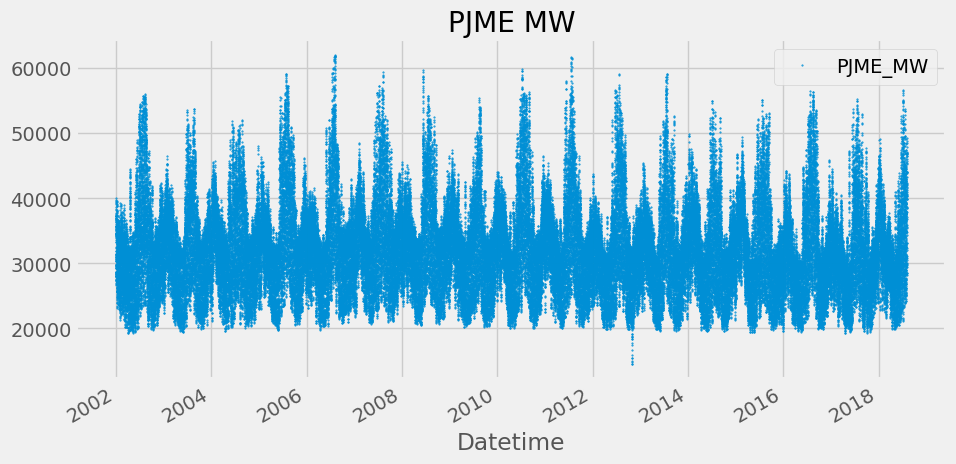

In [8]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

In [9]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

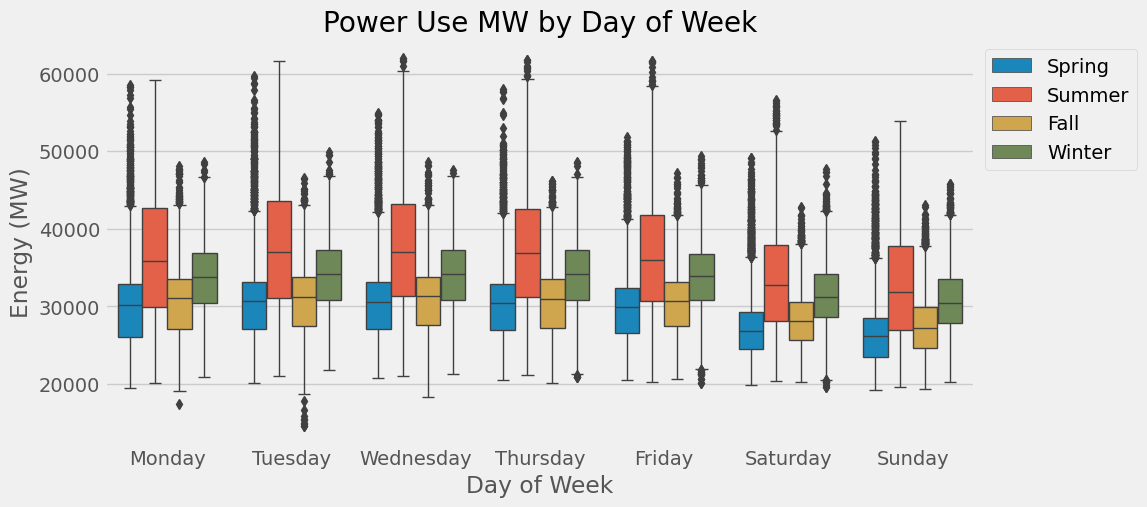

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [11]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [14]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


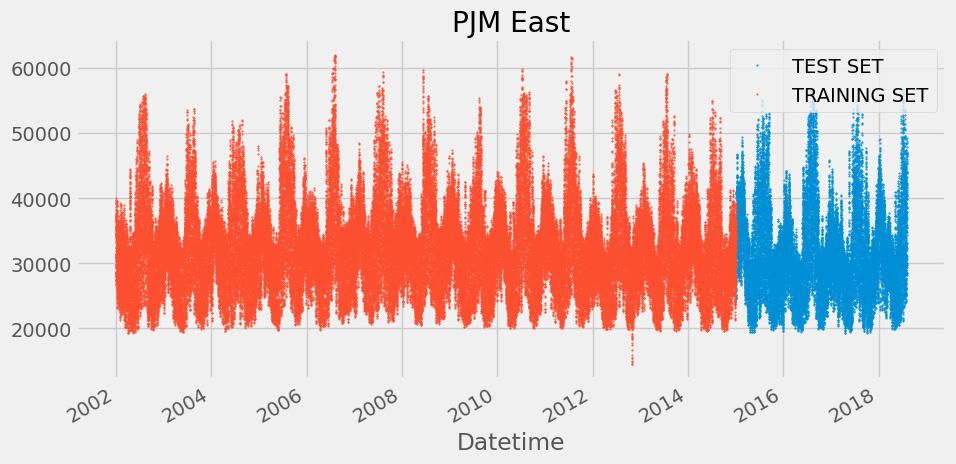

In [12]:


# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

ĐỔI SANG DS


In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import LSTM, Dense,Dropout

from tensorflow.keras.callbacks import EarlyStopping
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
pjme_train_scaled = scaler.fit_transform(pjme_train)
pjme_test_scaled = scaler.transform(pjme_test)

# Chuyển đổi dữ liệu thành định dạng tensor 3D
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


TIME_STEPS = 24  
X_train, y_train = create_dataset(pjme_train_scaled, pjme_train_scaled[:, 0], TIME_STEPS)

X_test, y_test = create_dataset(pjme_test_scaled, pjme_test_scaled[:, 0], TIME_STEPS)


# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=200, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=150, batch_size=64, validation_split=0.1, verbose=1,callbacks=[monitor])

# Đánh giá mô hình trên tập kiểm tra
model.evaluate(X_test, y_test)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)


2024-05-12 07:51:34.927790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 07:51:34.927915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 07:51:35.094214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/150
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0055 - val_loss: 6.0326e-04
Epoch 2/150
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 7.5803e-04 - val_loss: 3.8445e-04
Epoch 3/150
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 5.1777e-04 - val_loss: 3.4099e-04
Epoch 4/150
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.4038e-04 - val_loss: 3.1849e-04
Epoch 5/150
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.8476e-04 - val_loss: 3.0284e-04
Epoch 6/150
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.4919e-04 - val_loss: 2.8109e-04
Epoch 7/150
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.3418e-04 - val_loss: 2.6488e-04
Epoch 8/150
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.1336e-04 - val_loss: 2.9496e-04
Epoch 9/150
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.0089e-04 - val_loss: 2.4480e-04
Epoch 10/150
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.8567e-04 - val_loss: 2.8122e-04
Epoch 11/150
1602/1602 ━━━━━━━━━

In [14]:
yaaa = model.evaluate(X_test, y_test)
yaaa

982/982 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.4211e-04


0.0005835082847625017

In [16]:
# Nghịch đảo quá trình chuẩn hóa
y_pred_inverse = scaler.inverse_transform(y_pred)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Root Mean Squared Error (RMSE)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_inverse))

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_inverse)

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred_inverse.flatten())

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)



Root Mean Squared Error (RMSE): 31839.370035951833
Mean Absolute Error (MAE): 31215.44512407344
Mean Absolute Percentage Error (MAPE): 9541834.542224154


In [20]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
pjme_train_prophet = pjme_train_prophet.drop_duplicates(subset='ds')

In [21]:
# Đổi tên cột chứa thời điểm từ 'Datetime' thành 'ds'

pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
pjme_test_prophet = pjme_test_prophet.drop_duplicates(subset='ds')

In [22]:
pjme_test_prophet

,ds,y
0,2015-12-31 01:00:00,24305.0
1,2015-12-31 02:00:00,23156.0
2,2015-12-31 03:00:00,22514.0
3,2015-12-31 04:00:00,22330.0
4,2015-12-31 05:00:00,22773.0
...,...,...
31434,2018-01-01 20:00:00,44284.0
31435,2018-01-01 21:00:00,43751.0
31436,2018-01-01 22:00:00,42402.0
31437,2018-01-01 23:00:00,40164.0


In [23]:
# 1. Huấn luyện mô hình NeuralProphet
model_neuralprophet = NeuralProphet(
    n_forecasts=24, # Dự đoán 24 giờ tiếp theo
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    batch_size=64,
    epochs=100,
    learning_rate=0.1
)
model_neuralprophet.fit(pjme_train_prophet, freq='H')

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 95.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,3678.586426,4792.313965,0.037428,0.0,0
1,2848.773682,3766.010010,0.019792,0.0,1
2,2858.157227,3765.120361,0.019872,0.0,2
3,2881.186768,3798.243164,0.020207,0.0,3
4,2921.946289,3842.137939,0.020634,0.0,4
...,...,...,...,...,...
95,2676.026123,3566.273193,0.017849,0.0,95
96,2673.063477,3564.900146,0.017831,0.0,96
97,2671.765137,3561.829102,0.017802,0.0,97
98,2671.834473,3559.954834,0.017801,0.0,98


In [110]:
# # Dự đoán trên tập kiểm tra với NeuralProphet
# # Tạo một DataFrame tương lai cho NeuralProphet dựa trên số lượng bước thời gian trong 30 ngày tương lai
# future = model_neuralprophet.make_future_dataframe(pjme_test_prophet, periods=720, n_historic_predictions=1440)

# forecast_neuralprophet = model_neuralprophet.predict(future)



In [100]:
forecast_neuralprophet = model_neuralprophet.predict(pjme_test_prophet)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 95.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 95.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 1781it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [113]:
forecast_neuralprophet.tail()

,ds,y,yhat1,trend,season_yearly,season_weekly,season_daily
31431,2018-01-01 20:00:00,44284.0,37268.500000,30559.906250,1336.903931,1320.831543,4050.854980
31432,2018-01-01 21:00:00,43751.0,36802.648438,30559.882812,1338.831055,1369.183350,3534.751953
31433,2018-01-01 22:00:00,42402.0,35408.796875,30559.859375,1341.113647,1410.961060,2096.863770
31434,2018-01-01 23:00:00,40164.0,33204.765625,30559.835938,1343.122559,1441.118042,-139.312851
31435,2018-01-02 00:00:00,38608.0,30749.900391,30559.810547,1345.197388,1465.799561,-2620.907227


In [130]:
model_neuralprophet.plot(forecast_neuralprophet1)

ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [46]:
# Lấy dự đoán từ NeuralProphet
y_pred_neuralprophet = forecast_neuralprophet.yhat1.values


In [47]:
y_pred_neuralprophet 


array([28934.332, 27734.54 , 27115.336, ..., 35408.797, 33204.766,
       30749.9  ], dtype=float32)

In [48]:
y_pred_neuralprophet = y_pred_neuralprophet[-len(y_pred_inverse):]


In [49]:
y_pred_neuralprophet 

array([35398.348, 33156.086, 30648.727, ..., 35408.797, 33204.766,
       30749.9  ], dtype=float32)

In [50]:

# Kết hợp dự đoán từ NeuralProphet và LSTM
y_pred_ensemble = (y_pred_neuralprophet + y_pred_inverse.flatten()) / 2

# Tính toán các chỉ số độ đo trên tập kiểm tra
rmse_ensemble = math.sqrt(mean_squared_error(pjme_test.iloc[TIME_STEPS:], y_pred_ensemble))
mae_ensemble = mean_absolute_error(pjme_test.iloc[TIME_STEPS:], y_pred_ensemble)
mape_ensemble = mean_absolute_percentage_error(pjme_test.iloc[TIME_STEPS:], y_pred_ensemble)

print("Root Mean Squared Error (RMSE) của ensemble model:", rmse_ensemble)
print("Mean Absolute Error (MAE) của ensemble model:", mae_ensemble)
print("Mean Absolute Percentage Error (MAPE) của ensemble model:", mape_ensemble)

Root Mean Squared Error (RMSE) của ensemble model: 2409.115217827964
Mean Absolute Error (MAE) của ensemble model: 1835.3072091855006
Mean Absolute Percentage Error (MAPE) của ensemble model: 21.60488257324844


In [ ]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(pjme)
plt.plot(forecast_neuralprophet)

In [51]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# Giả sử y_pred_ensemble là đầu vào, và chúng ta cần chuẩn hóa nó
# Bạn có thể thêm các bước chuẩn hóa nếu cần
# Đầu vào là kết hợp của dự đoán từ LSTM và NeuralProphet
X_ensemble = np.column_stack((y_pred_neuralprophet, y_pred_inverse.flatten()))

# Chuẩn bị đầu ra là giá trị thực tế từ tập kiểm tra, lấy sau TIME_STEPS do trượt cửa sổ
y_true = pjme_test['PJME_MW'][TIME_STEPS:]

# Xây dựng mô hình ANN
model_ensemble = Sequential()
model_ensemble.add(Dense(50, input_dim=2, activation='relu'))
model_ensemble.add(Dense(1))
model_ensemble.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Huấn luyện mô hình
model_ensemble.fit(X_ensemble, y_true, epochs=100, batch_size=32, validation_split=0.1)

# Đánh giá mô hình
loss, mae = model_ensemble.evaluate(X_ensemble, y_true)
print("Mean Absolute Error (MAE) của ANN:", mae)

# Dự đoán sử dụng mô hình ANN
y_pred_ann = model_ensemble.predict(X_ensemble)

# Tính RMSE, MAE, MAPE
rmse_ann = math.sqrt(mean_squared_error(y_true, y_pred_ann))
mae_ann = mean_absolute_error(y_true, y_pred_ann)
mape_ann = mean_absolute_percentage_error(y_true, y_pred_ann.flatten())

print("Root Mean Squared Error (RMSE) của ANN:", rmse_ann)
print("Mean Absolute Error (MAE) của ANN:", mae_ann)
print("Mean Absolute Percentage Error (MAPE) của ANN:", mape_ann)


Epoch 1/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 37710792.0000 - mae: 3437.3494 - val_loss: 1421054.8750 - val_mae: 881.3295
Epoch 2/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1322020.2500 - mae: 851.6830 - val_loss: 1459027.2500 - val_mae: 905.1633
Epoch 3/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1320774.7500 - mae: 853.7256 - val_loss: 1392336.1250 - val_mae: 856.8252
Epoch 4/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1293955.5000 - mae: 844.9840 - val_loss: 1412397.6250 - val_mae: 880.2906
Epoch 5/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1302952.0000 - mae: 846.1534 - val_loss: 1393816.2500 - val_mae: 867.2895
Epoch 6/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1313566.0000 - mae: 858.2576 - val_loss: 1450038.6250 - val_mae: 900.9773
Epoch 7/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1348207.1250 - mae: 860.5645 - val_loss: 1569860.7500 - val_mae: 958.7202
Epoch 8/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step 

TEST